### Group Project 4 : Comparing 3 Models for Predicting Recidivism

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- Exploratory Data Analysis (this notebook)
- [Modeling](./03_modeling.ipynb)
- [Experiments](./03a_experiments.ipynb)
- [Results and Recommendations](./04_results.ipynb)

**In this notebook, you'll find:**
- Baseline accuracy
- TODO etc.

**Model 1: Base feature set - New York**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%store -r ny_df

In [3]:
#Based on a quick review of the stats we can see the average ages and distribution of ages at release which mainly range between 26 and 44 years old.
#We can also see the data spans release years between 2008 and 2015
ny_df.describe()

,Release Year,Age at Release,recidivism,gender_map
count,188650.000000,188650.000000,188650.000000,188650.000000
mean,2011.326064,35.473400,0.416894,0.937228
std,2.289170,10.972873,0.493046,0.242554
min,2008.000000,16.000000,0.000000,0.000000
25%,2009.000000,26.000000,0.000000,1.000000
50%,2011.000000,34.000000,0.000000,1.000000
75%,2013.000000,44.000000,1.000000,1.000000
max,2015.000000,100.000000,1.000000,1.000000


##### Baseline

In [8]:
#Breakdown of Return Status: For modeling I will combine returned parole violation and returned new felony as these both represent recidivism
ny_df['Return Status'].value_counts(normalize = True)

Not Returned                 0.583106
Returned Parole Violation    0.325370
New Felony Offense           0.091524
Name: Return Status, dtype: float64

In [6]:
#Baseline Metrics for Model Evaluation: Majority Class, Not Returned, represents 58% of the observations which will serve as the baseline model accuracy
ny_df['recidivism'].value_counts(normalize = True)

0    0.583106
1    0.416894
Name: recidivism, dtype: float64

##### Age at Release

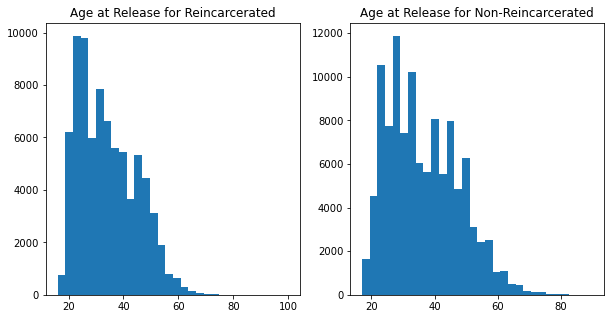

In [11]:
#Distribution of the Age at Release is pretty similar between those who are reincarcerated and those who are not with reincarcerated trending slightly lower in age.
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].hist(ny_df[ny_df['recidivism'] == 1]['Age at Release'], bins = 30)
ax[0].set_title('Age at Release for Reincarcerated')
ax[1].hist(ny_df[ny_df['recidivism'] == 0]['Age at Release'], bins = 30)
ax[1].set_title('Age at Release for Non-Reincarcerated');

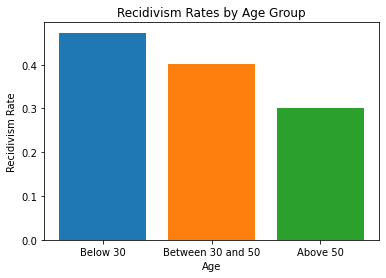

In [12]:
#split the dataset into different age ranges below 30, 30-50, 50 and above
below30 = ny_df[ny_df['Age at Release'] < 30]
between_30_50 = ny_df[(ny_df['Age at Release'] >= 30) & (ny_df['Age at Release'] <= 50)]
above50 = ny_df[ny_df['Age at Release'] > 50]

#calculate recidivism rate for each age group as recidivism = reincarcerated / total pop
below30_recid_rate = (below30[below30['recidivism'] == 1]['recidivism'].value_counts()) / below30.shape[0]
between_30_50_recid_rate = (between_30_50[between_30_50['recidivism'] == 1]['recidivism'].value_counts()) / between_30_50.shape[0]
above_50_recid_rate = (above50[above50['recidivism'] == 1]['recidivism'].value_counts()) / above50.shape[0]

#Here we can see a steady decline in recidivism rates as the age at release increases. 
plt.bar(x = 'Below 30', height= below30_recid_rate)
plt.bar(x = 'Between 30 and 50', height = between_30_50_recid_rate)
plt.bar(x = 'Above 50', height = above_50_recid_rate)
plt.xlabel('Age')
plt.ylabel('Recidivism Rate')
plt.title('Recidivism Rates by Age Group');

##### Gender

In [13]:
male = ny_df[ny_df['Gender'] == 'MALE']
female = ny_df[ny_df['Gender'] == 'FEMALE']

In [14]:
#Males represent an overwhelming ~94% of the observations as such it may be difficult to draw accurate comparisons with only ~12k female observations v. 176k males. 
print(f'Count of Female Observations: {female.shape[0]}')
print(f'Count of Male Observations: {male.shape[0]}')
ny_df['Gender'].value_counts(normalize = True)

Count of Female Observations: 11842
Count of Male Observations: 176808


MALE      0.937228
FEMALE    0.062772
Name: Gender, dtype: float64

In [15]:
male.describe() 

,Release Year,Age at Release,recidivism,gender_map
count,176808.000000,176808.000000,176808.000000,176808.0
mean,2011.327734,35.376476,0.425145,1.0
std,2.286653,11.000085,0.494366,0.0
min,2008.000000,16.000000,0.000000,1.0
25%,2009.000000,26.000000,0.000000,1.0
50%,2011.000000,33.000000,0.000000,1.0
75%,2013.000000,44.000000,1.000000,1.0
max,2015.000000,100.000000,1.000000,1.0


In [16]:
female.describe()

,Release Year,Age at Release,recidivism,gender_map
count,11842.000000,11842.000000,11842.000000,11842.0
mean,2011.301132,36.920537,0.293700,0.0
std,2.326383,10.452333,0.455476,0.0
min,2008.000000,17.000000,0.000000,0.0
25%,2009.000000,28.000000,0.000000,0.0
50%,2011.000000,36.000000,0.000000,0.0
75%,2013.000000,45.000000,1.000000,0.0
max,2015.000000,86.000000,1.000000,0.0


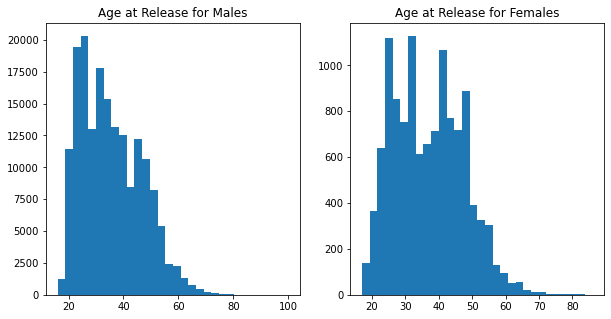

In [17]:
#The distrubtion of age at release is slightly lower for men as oppossed to women. Avg age at release for women is 37 versus 35 for men.
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].hist(male['Age at Release'], bins = 30)
ax[0].set_title('Age at Release for Males')
ax[1].hist(female['Age at Release'], bins = 30)
ax[1].set_title('Age at Release for Females');

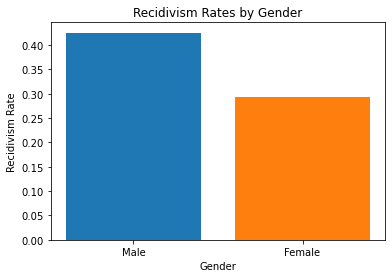

In [18]:
#Men have a 13% higher recidivism rate then women. 
plt.bar(x = 'Male', height= male[male['recidivism'] == 1]['recidivism'].value_counts() / male.shape[0])
plt.bar(x = 'Female', height = female[female['recidivism'] == 1]['recidivism'].value_counts() / female.shape[0])
plt.xlabel('Gender')
plt.ylabel('Recidivism Rate')
plt.title('Recidivism Rates by Gender');

##### County of Indictment

In [19]:
#There are 63 different counties of indictment however ~80% of observations come from 15 counties.
ny_df['County of Indictment'].value_counts(normalize = True)[:15]

NEW YORK       0.182067
KINGS          0.104394
BRONX          0.094355
QUEENS         0.070167
SUFFOLK        0.049632
MONROE         0.045460
ERIE           0.043615
ONONDAGA       0.033485
NASSAU         0.031625
ALBANY         0.031248
WESTCHESTER    0.023393
ORANGE         0.023096
ONEIDA         0.018669
BROOME         0.015823
SCHENECTADY    0.014583
Name: County of Indictment, dtype: float64

In [20]:
#Recidivism Rates by County of Indictment (showing the top 15 recidivism rates per county)
ny_df.groupby(['County of Indictment'])['recidivism'].mean().sort_values(ascending = False)[:15]

County of Indictment
MONROE         0.525770
ERIE           0.505105
SCHENECTADY    0.504907
CHEMUNG        0.501913
BROOME         0.497822
TOMPKINS       0.497630
CHAUTAUQUA     0.491356
TIOGA          0.485043
RENSSELAER     0.483302
CORTLAND       0.482866
ULSTER         0.482848
ONONDAGA       0.481716
SENECA         0.477663
ALBANY         0.475997
OSWEGO         0.474727
Name: recidivism, dtype: float64

In [21]:
%store ny_df

Stored 'ny_df' (DataFrame)


**Model 2: Criminal history feature set - Florida**

**Model 3: Behavioral feature set - Georgia**

In [2]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [4]:
# Reading in the cleaned data

ga = pd.read_csv('../data/GA/georgia_cleaned.csv')
ga.drop(columns = 'Unnamed: 0', inplace=True)
ga.head()

,gender_male,age_at_release,gang_affiliated,supervision_risk_score_first,education_level,dependents,prison_years,prior_arrest_episodes_felony,prior_arrest_episodes_misd,prior_arrest_episodes_violent,...,delinquency_reports,program_attendances,residence_changes,avg_days_per_drugtest,drugtests_thc_positive,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,recidivism_within_3years
0,1,43-47,0,3.0,at least some college,3,more than 3 years,6,6,1,...,0,6,2,612.000000,0.000000,0.0,0.000000,0.0,0.488562,0
1,1,33-37,0,6.0,less than hs diploma,1,more than 3 years,7,6,3,...,4,0,2,35.666667,0.000000,0.0,0.000000,0.0,0.425234,1
2,1,48 or older,0,7.0,at least some college,3,1-2 years,6,6,3,...,4,6,0,93.666667,0.333333,0.0,0.166667,0.0,0.000000,1
3,1,38-42,0,7.0,less than hs diploma,1,1-2 years,8,6,0,...,0,6,3,25.400000,0.000000,0.0,0.000000,0.0,1.000000,0
4,1,33-37,0,4.0,less than hs diploma,3,1-2 years,4,4,3,...,0,7,0,23.117647,0.000000,0.0,0.058824,0.0,0.203562,1


### Are certain demographic classes more likely to be reincarcerated?

#### Age

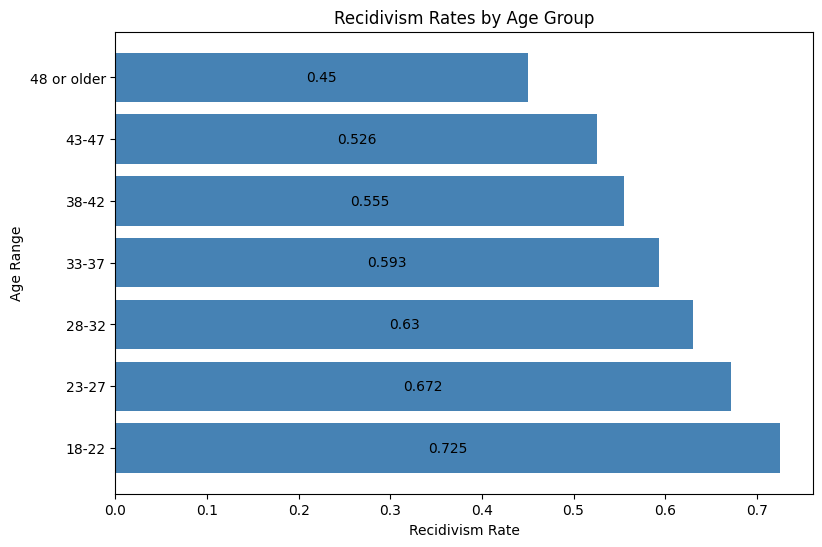

In [9]:
age_recidivism = ga.groupby(by = ['age_at_release'])['recidivism_within_3years'].value_counts(normalize=True)
age_recidivism = pd.DataFrame(age_recidivism)

fig, ax = plt.subplots(figsize=(9, 6))

y_vals = [val for val, bool in age_recidivism.index[::2]]
recid_pcts = [round(val,3) for val in age_recidivism['recidivism_within_3years'][0:-2][::2]]
recid_pcts.append(round(age_recidivism['recidivism_within_3years'][-2:][1], 3))
age_plot = ax.barh(y=y_vals, 
    width=recid_pcts, color='steelblue')
ax.bar_label(age_plot, label_type='center')
ax.set(title='Recidivism Rates by Age Group', xlabel='Recidivism Rate', ylabel='Age Range')
plt.show();

We can see a clear pattern here of those in the younger age groups being more likely to recidivate than those in the older groups. The lowest rate is among those in the 48 or older age range, and the highest rate of more than 72% is seen in 18-22 year olds.

#### Gender

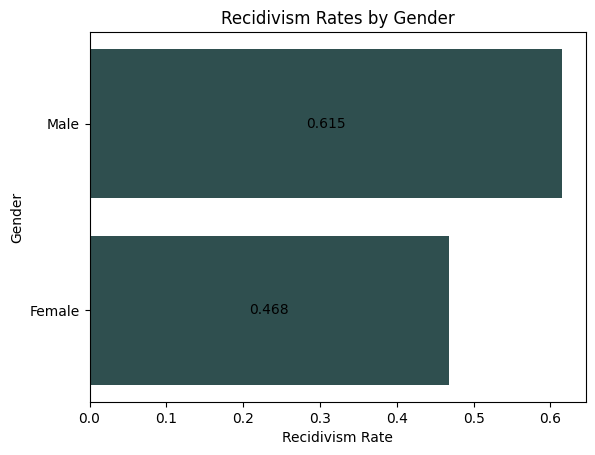

In [10]:
gender_recidivism = ga.groupby(by = ['gender_male'])['recidivism_within_3years'].value_counts(normalize=True)
gender_recidivism = pd.DataFrame(gender_recidivism)

fig, ax = plt.subplots()

y_vals = [val for val, bool in gender_recidivism.index[::2]]
recid_pcts = [round(val, 3) for val in gender_recidivism['recidivism_within_3years'][1:3]]
gender_plot = ax.barh(y=y_vals, 
    width=recid_pcts, color='darkslategray')
ax.bar_label(gender_plot, label_type='center')
ax.set(title='Recidivism Rates by Gender', xlabel='Recidivism Rate', ylabel='Gender', yticks=[0, 1], yticklabels=['Female', 'Male'])
plt.show();

Holding all else equal, men are about 15% more likely to be reincarcerated than women.

#### Number of Dependents

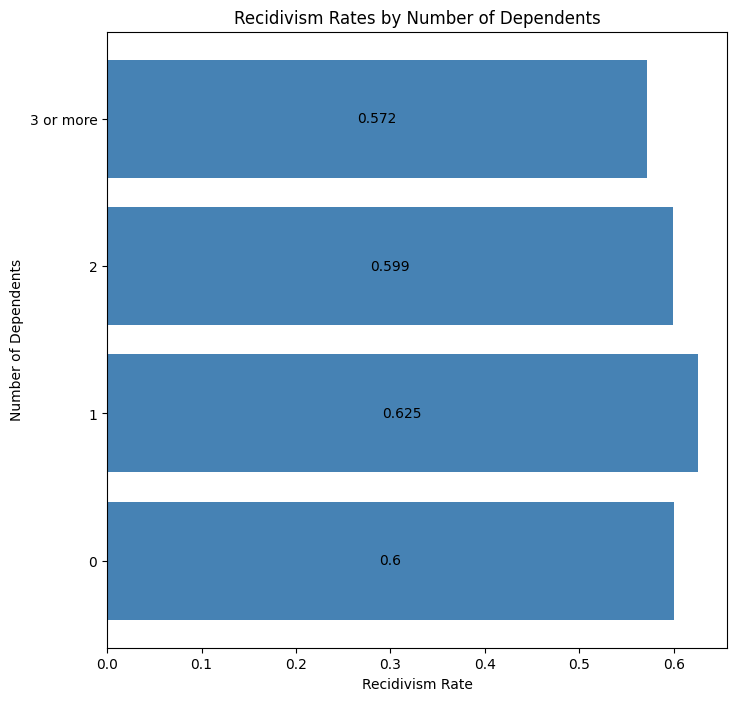

In [12]:
dpndts_recidivism = ga.groupby(by = ['dependents'])['recidivism_within_3years'].value_counts(normalize=True)
dpndts_recidivism = pd.DataFrame(dpndts_recidivism)

fig, ax = plt.subplots(figsize = (8,8))

y_vals = [val for val, bool in dpndts_recidivism.index[::2]]
recid_pcts = [round(val, 3) for val in dpndts_recidivism['recidivism_within_3years'][::2]]
dpndts_plot = ax.barh(y=y_vals, 
    width=recid_pcts, color='steelblue')
ax.bar_label(dpndts_plot, label_type='center')
ax.set(title='Recidivism Rates by Number of Dependents', xlabel='Recidivism Rate', ylabel='Number of Dependents', yticks=[0, 1, 2, 3], yticklabels=[0, 1, 2, '3 or more'])
plt.show();

The recidivism rates appear to be evenly distributed and not highly correlated with any number of dependents.

#### Education Level

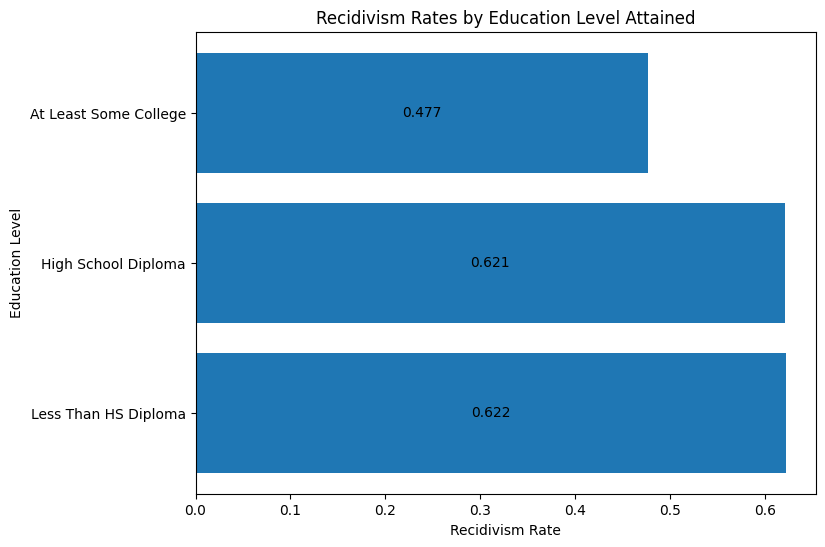

In [88]:
education_recidivism = ga.groupby(by = ['education_level'])['recidivism_within_3years'].value_counts(normalize=True)
education_recidivism = pd.DataFrame(education_recidivism)

fig, ax = plt.subplots(figsize=(8, 6))

y_vals = [val for val, bool in education_recidivism.index[::2]]
recid_pcts = [round(val,3) for val in education_recidivism['recidivism_within_3years'][1:3]]
recid_pcts.append(round(education_recidivism['recidivism_within_3years'][4], 3))
edu_plot = ax.barh(y=y_vals[::-1], 
    width=recid_pcts[::-1])
ax.bar_label(edu_plot, label_type='center')
ax.set(title='Recidivism Rates by Education Level Attained', xlabel='Recidivism Rate', ylabel='Education Level', yticks=[0, 1, 2], yticklabels=['Less Than HS Diploma', 'High School Diploma', 'At Least Some College'])
plt.show();

We can see here that the lowest recidivism rate is seen in those that have at least some college experience. Those who did not graduate from high school and those who do not have any education beyond a high school diploma have similar average recidivism rates of about 62%. 

*Note: These education levels are what had been achieved upon prison entry.*

#### Gang Affiliation

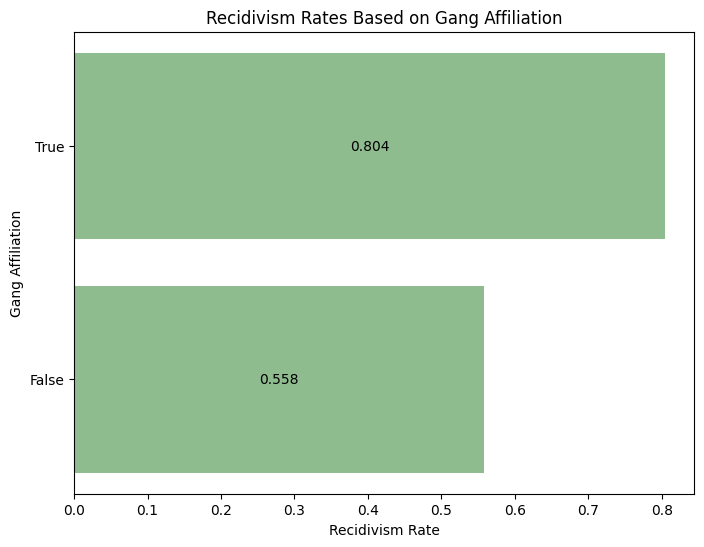

In [19]:
gang_recidivism = ga.groupby(by = ['gang_affiliated'])['recidivism_within_3years'].value_counts(normalize=True)
gang_recidivism = pd.DataFrame(gang_recidivism)

fig, ax = plt.subplots(figsize=(8,6))

y_vals = [val for val, bool in gang_recidivism.index[::2]]
recid_pcts = [round(val,3) for val in gang_recidivism['recidivism_within_3years'][::2]]
gang_plot = ax.barh(y=y_vals, 
    width=recid_pcts, color='darkseagreen')
ax.bar_label(gang_plot, label_type='center')
ax.set(title='Recidivism Rates Based on Gang Affiliation', xlabel='Recidivism Rate', ylabel='Gang Affiliation', yticks=[0, 1], yticklabels=['False', 'True'])
plt.show();

In [87]:
ga.groupby(by = ['gang_affiliated'])['prior_arrests_total'].mean()

gang_affiliated
0    16.765536
1    15.468651
Name: prior_arrests_total, dtype: float64

There appears to be a clear trend here that those who have been confirmed as gang-affiliated are more likely to recidivate than those who are not.

### Do previous prison or parole experiences indicate a higher likelihood of recidivism?

#### Time Spent in Prison Prior to Most Recent Arrest

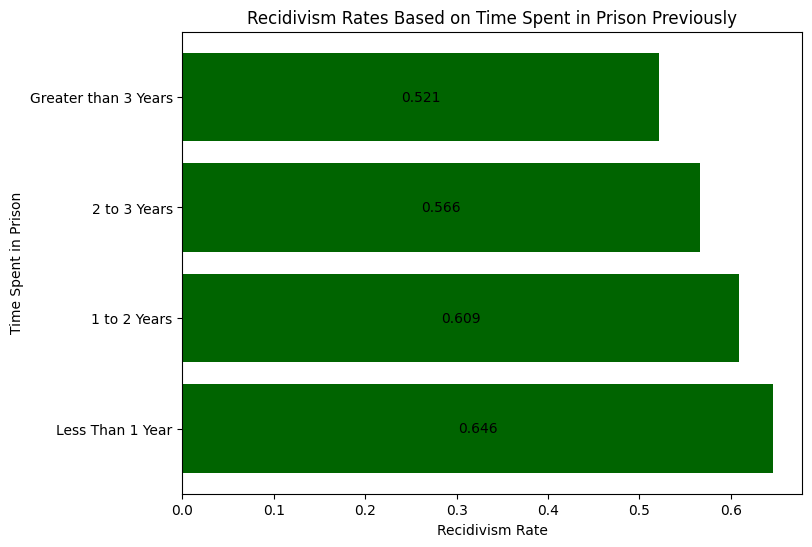

In [20]:
prison_years_recidivism = ga.groupby(by = ['prison_years'])['recidivism_within_3years'].value_counts(normalize=True)
prison_years_recidivism = pd.DataFrame(prison_years_recidivism)

prison_years_df = prison_years_recidivism.reset_index(drop=True)
prison_years_df['prison_time'] = ['1-2 years', '1-2 years', 'greater than 2 to 3 years', 'greater than 2 to 3 years', 'less than 1 year', 'less than 1 year', 'more than 3 years', 'more than 3 years']
prison_years_sorted = prison_years_df[::2].sort_values(by='recidivism_within_3years')

fig, ax = plt.subplots(figsize=(8,6))

y_vals = [val for val in prison_years_sorted['prison_time']]
recid_pcts = [round(val,3) for val in prison_years_sorted['recidivism_within_3years']]
py_plot = ax.barh(y=y_vals[::-1], 
    width=recid_pcts[::-1], color='darkgreen')
ax.bar_label(py_plot, label_type='center')
ax.set(title='Recidivism Rates Based on Time Spent in Prison Previously', xlabel='Recidivism Rate', ylabel='Time Spent in Prison', yticks=[0, 1, 2, 3], yticklabels=['Less Than 1 Year', '1 to 2 Years', '2 to 3 Years', 'Greater than 3 Years'])
plt.show();

Interestingly, those who spent less time in prison previously are more likely to recidivate compared to those that spent a longer amount of time in prison before being released.

#### First Parole Supervision Risk Assessment Score

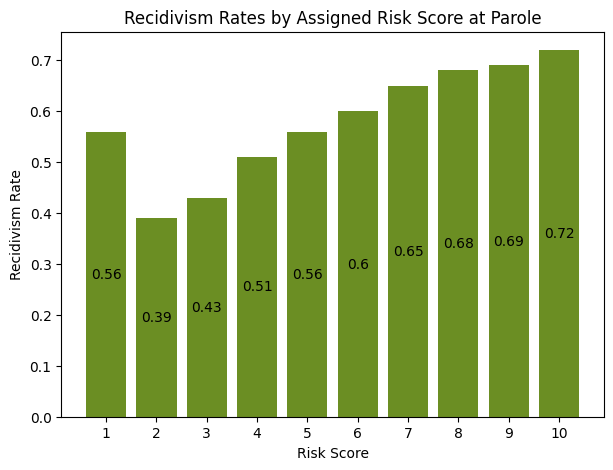

In [24]:
risk_score_recidivism = ga.groupby(by = ['supervision_risk_score_first'])['recidivism_within_3years'].value_counts(normalize=True)
risk_score_recidivism = pd.DataFrame(risk_score_recidivism)
risk_range = list(range(1,11))

fig, ax = plt.subplots(figsize=(7,5))

x_vals = [val for val, bool in risk_score_recidivism.index[::2]]
recid_pcts = [round(risk_score_recidivism['recidivism_within_3years'][1][1], 2)]
recid_pcts.extend(list(round(risk_score_recidivism['recidivism_within_3years'][3:6][::2],2)))
recid_pcts.extend([round(val,2) for val in risk_score_recidivism['recidivism_within_3years'][6:][::2]])
risk_plot = ax.bar(x=x_vals, 
    height=recid_pcts, color='olivedrab')
ax.bar_label(risk_plot, label_type='center')
ax.set(title='Recidivism Rates by Assigned Risk Score at Parole', xlabel='Risk Score', ylabel='Recidivism Rate', xticks=risk_range, xticklabels=risk_range)
plt.show();

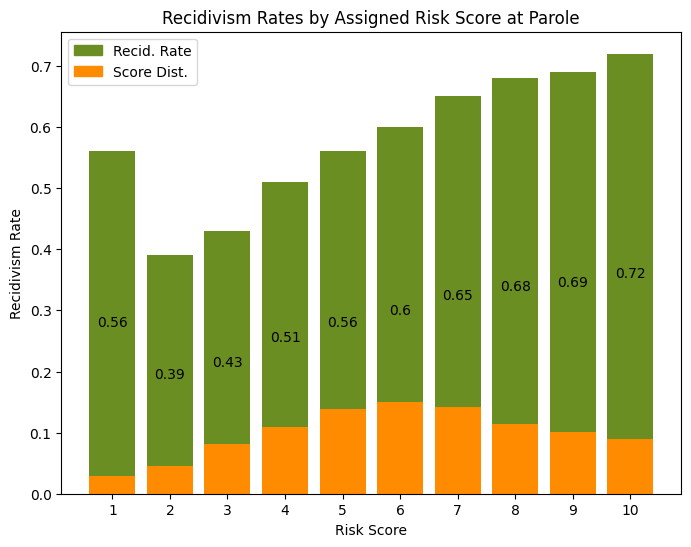

In [25]:
# Showing the same plot, including the distribution of risk scores given

risk_score_recidivism = ga.groupby(by = ['supervision_risk_score_first'])['recidivism_within_3years'].value_counts(normalize=True)
risk_score_recidivism = pd.DataFrame(risk_score_recidivism)
risk_range = list(range(1,11))

fig, ax = plt.subplots(figsize=(8,6))

x_vals = [val for val, bool in risk_score_recidivism.index[::2]]
recid_pcts = [round(risk_score_recidivism['recidivism_within_3years'][1][1], 2)]
recid_pcts.extend(list(round(risk_score_recidivism['recidivism_within_3years'][3:6][::2],2)))
recid_pcts.extend([round(val,2) for val in risk_score_recidivism['recidivism_within_3years'][6:][::2]])
risk_plot = ax.bar(x=x_vals, 
    height=recid_pcts, color='olivedrab')
ax.bar_label(risk_plot, label_type='center')
ax.set(title='Recidivism Rates by Assigned Risk Score at Parole', xlabel='Risk Score', ylabel='Recidivism Rate', xticks=risk_range, xticklabels=risk_range)
ax.bar(height= ga['supervision_risk_score_first'].value_counts(normalize=True).sort_index(axis=0), x=risk_range, color='darkorange')
recid_rates = mpatches.Patch(color='olivedrab', label='Recid. Rate')
risk_score_pcts = mpatches.Patch(color='darkorange', label='Score Dist.')
plt.legend(handles=[recid_rates, risk_score_pcts])
plt.show();

Based on the above, it appears that the scorers who are evaluating the individuals' risk at parole are mostly correct for scores 2 through 10. There is a discrepancy when a score of 1 is given, in that the risk level is perceived as low but more than half of these individuals did end up being rearrested.

#### Prior Arrest Episodes

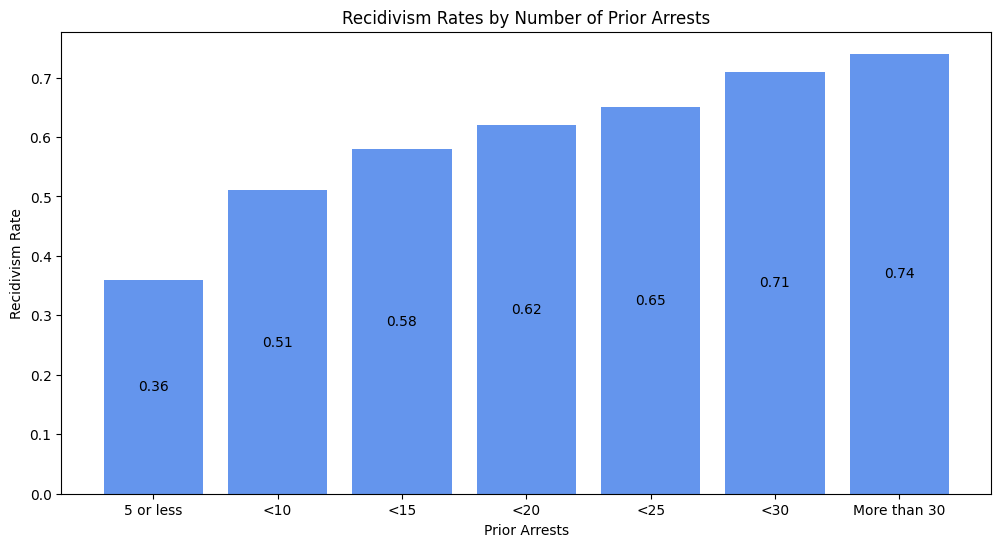

In [26]:
# Adding column to sum all prior arrests
prior_arrest_cols = [col for col in ga if col.startswith('prior_arrest')]
ga['prior_arrests_total'] = ga[prior_arrest_cols].iloc[:, :-2].sum(axis=1)

# Now adding a column here so that we're able to categorize the individual values within the prior_arrests_total column, and thus, better summarize the data

ga['prior_arrests_total_categ'] = pd.cut(ga['prior_arrests_total'], bins=7, labels=['5 or less', '<10', '<15', '<20', '<25', '<30', 'More than 30'])

arrests_recidivism = ga.groupby(by = ['prior_arrests_total_categ'])['recidivism_within_3years'].value_counts(normalize=True)
arrests_recidivism = pd.DataFrame(arrests_recidivism)

fig, ax = plt.subplots(figsize=(12,6))

x_vals = [val for val, bool in arrests_recidivism.index[::2]]
recid_pcts = [round(arrests_recidivism['recidivism_within_3years'][1], 2)]
recid_pcts.extend([round(val,2) for val in arrests_recidivism['recidivism_within_3years'][2:-1][::2]])
arrest_plot = ax.bar(x=x_vals, height=recid_pcts, color='cornflowerblue')
ax.bar_label(arrest_plot, label_type='center')
ax.set(title='Recidivism Rates by Number of Prior Arrests', xlabel='Prior Arrests', ylabel='Recidivism Rate')
plt.show();

Based on the above, we could reasonably conclude that the more times an individual has been arrested in the past, the more likely they are to be arrested again.

#### Drug Use

In [ ]:
ga['']

#### Parole Violations

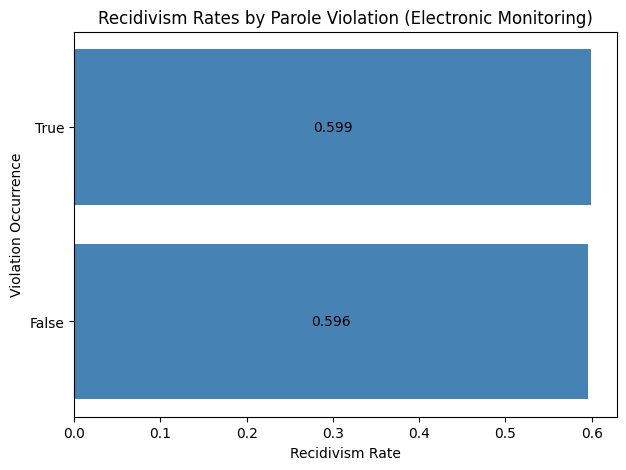

In [30]:
elecmonit_paroleviol_recidivism = ga.groupby(by = ['violations_electronicmonitoring'])['recidivism_within_3years'].value_counts(normalize=True)
elecmonit_paroleviol_recidivism = pd.DataFrame(elecmonit_paroleviol_recidivism)

fig, ax = plt.subplots(figsize=(7,5))

y_vals = [val for val in elecmonit_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3) for val in elecmonit_paroleviol_recidivism['recidivism_within_3years']]
em_pv_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='steelblue')
ax.bar_label(em_pv_plot, label_type='center')
ax.set(title='Recidivism Rates by Parole Violation (Electronic Monitoring)', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Violation Occurrence')
plt.show();

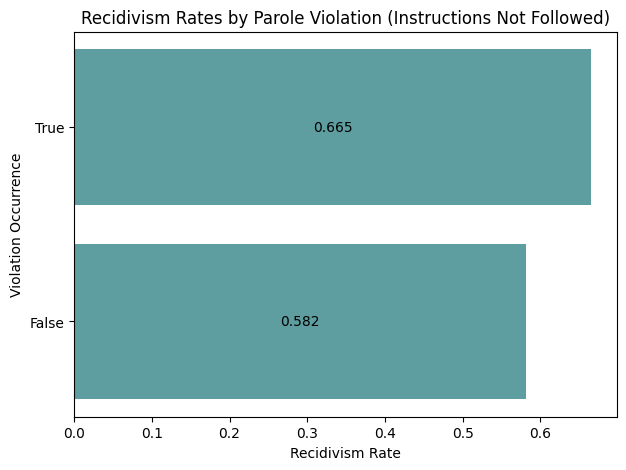

In [31]:
instruction_paroleviol_recidivism = ga.groupby(by = ['violations_instruction'])['recidivism_within_3years'].value_counts(normalize=True)
instruction_paroleviol_recidivism = pd.DataFrame(instruction_paroleviol_recidivism)

fig, ax = plt.subplots(figsize=(7,5))

y_vals = [val for val in instruction_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3) for val in instruction_paroleviol_recidivism['recidivism_within_3years']]
instr_pv_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='cadetblue')
ax.bar_label(instr_pv_plot, label_type='center')
ax.set(title='Recidivism Rates by Parole Violation (Instructions Not Followed)', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Violation Occurrence')
plt.show();

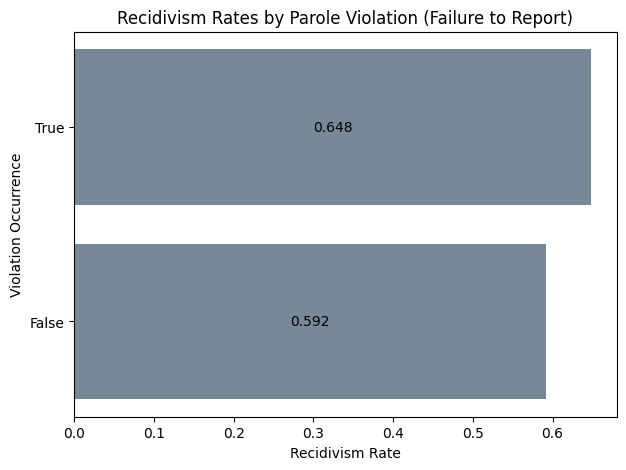

In [32]:
failtoreport_paroleviol_recidivism = ga.groupby(by = ['violations_failtoreport'])['recidivism_within_3years'].value_counts(normalize=True)
failtoreport_paroleviol_recidivism = pd.DataFrame(failtoreport_paroleviol_recidivism)

fig, ax = plt.subplots(figsize=(7,5))

y_vals = [val for val in failtoreport_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3) for val in failtoreport_paroleviol_recidivism['recidivism_within_3years']]
ftr_pv_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='lightslategrey')
ax.bar_label(ftr_pv_plot, label_type='center')
ax.set(title='Recidivism Rates by Parole Violation (Failure to Report)', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Violation Occurrence')
plt.show();

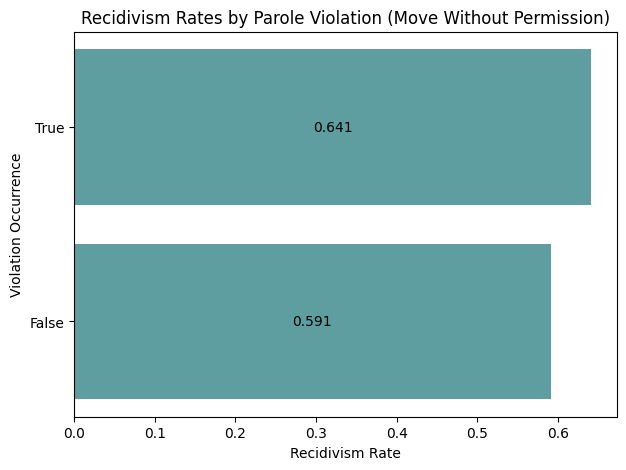

In [50]:
moving_paroleviol_recidivism = ga.groupby(by = ['violations_movewithoutpermission'])['recidivism_within_3years'].value_counts(normalize=True)
moving_paroleviol_recidivism = pd.DataFrame(moving_paroleviol_recidivism)

fig, ax = plt.subplots(figsize=(7,5))

y_vals = [val for val in moving_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3) for val in moving_paroleviol_recidivism['recidivism_within_3years']]
mwp_pv_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='cadetblue')
ax.bar_label(mwp_pv_plot, label_type='center')
ax.set(title='Recidivism Rates by Parole Violation (Move Without Permission)', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Violation Occurrence')
plt.show();

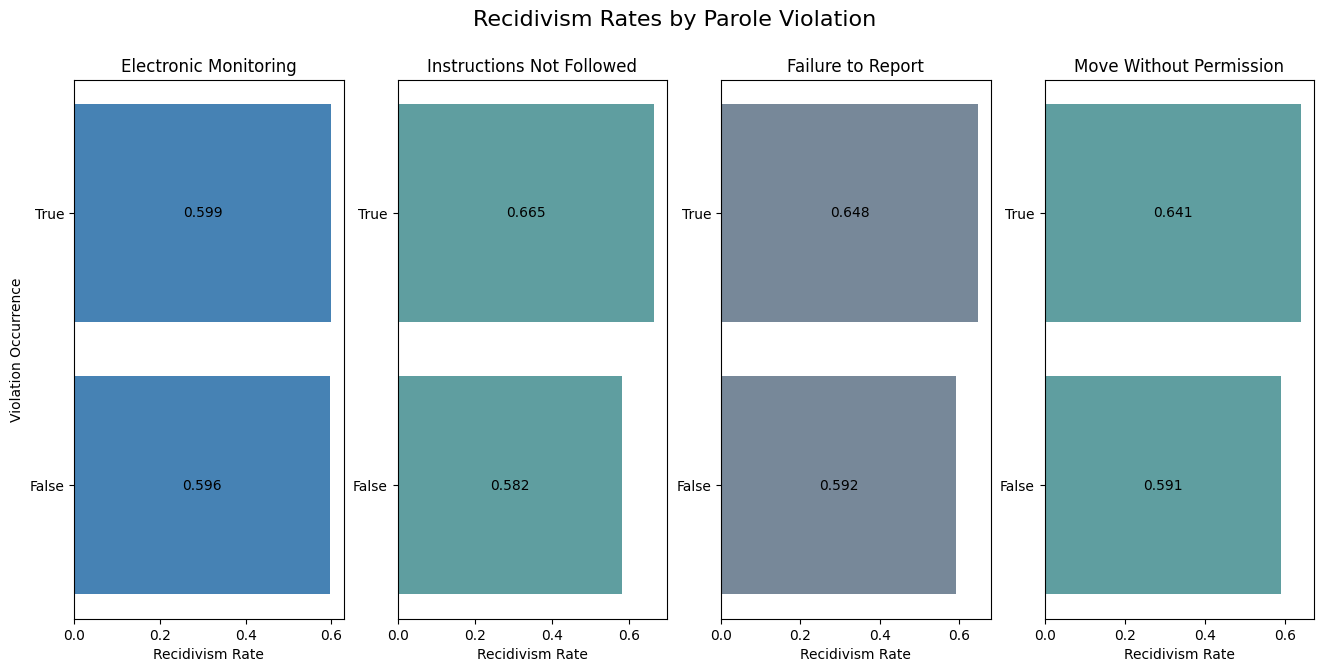

In [59]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,7))

y_vals = [val for val in elecmonit_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3) for val in elecmonit_paroleviol_recidivism['recidivism_within_3years']]
em_pv_plot = ax1.barh(y=y_vals, 
    width=recid_pcts[::2], color='steelblue')
ax1.bar_label(em_pv_plot, label_type='center')
ax1.set(title='Electronic Monitoring', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Violation Occurrence')

y_vals = [val for val in instruction_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3)  for val in instruction_paroleviol_recidivism['recidivism_within_3years']]
instr_pv_plot = ax2.barh(y=y_vals, 
    width=recid_pcts[::2], color='cadetblue')
ax2.bar_label(instr_pv_plot, label_type='center')
ax2.set(title='Instructions Not Followed', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate')

y_vals = [val for val in failtoreport_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3)  for val in failtoreport_paroleviol_recidivism['recidivism_within_3years']]
ftr_pv_plot = ax3.barh(y=y_vals, 
    width=recid_pcts[::2], color='lightslategrey')
ax3.bar_label(ftr_pv_plot, label_type='center')
ax3.set(title='Failure to Report', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate')

y_vals = [val for val in moving_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3)  for val in moving_paroleviol_recidivism['recidivism_within_3years']]
mwp_pv_plot = ax4.barh(y=y_vals, 
    width=recid_pcts[::2], color='cadetblue')
ax4.bar_label(mwp_pv_plot, label_type='center')
ax4.set(title='Move Without Permission', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate')

fig.suptitle('Recidivism Rates by Parole Violation', fontsize= 16)
plt.show();

While we do see a possible pattern between those who violate their parole and later end up recidivating, the connections are not necessarily strong enough to make any definitive statements. The biggest gaps in recidivism rates for parole violation occurrences are seen in the 'Instructions not Followed' and 'Failure to Report' violations. 

#### Delinquency Reports

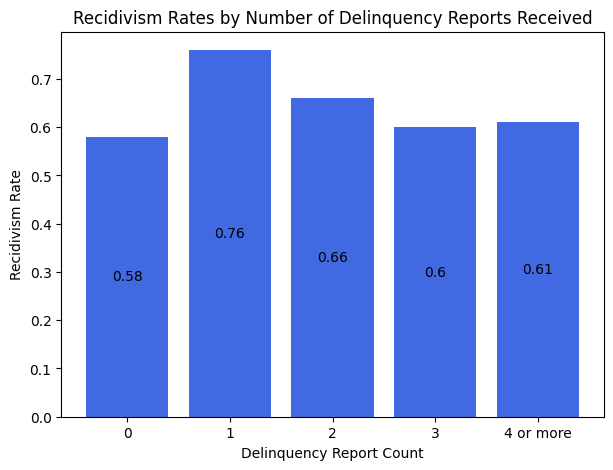

In [35]:
delinquency_recidivism = ga.groupby(by = ['delinquency_reports'])['recidivism_within_3years'].value_counts(normalize=True)
delinquency_recidivism = pd.DataFrame(delinquency_recidivism)

fig, ax = plt.subplots(figsize=(7,5))

x_vals = [val for val, bool in delinquency_recidivism.index[::2]]
recid_pcts = [round(val,2) for val in delinquency_recidivism['recidivism_within_3years'][::2]]
delinquency_plot = ax.bar(x=x_vals, 
    height=recid_pcts, color='royalblue')
ax.bar_label(delinquency_plot, label_type='center')
ax.set(title='Recidivism Rates by Number of Delinquency Reports Received', xlabel='Delinquency Report Count', ylabel='Recidivism Rate', xticks=[0,1,2,3,4], xticklabels=[0, 1, 2, 3,'4 or more'])
plt.show();

The graph above looks to have a bit of an odd trend on first glance, with the highest rate of recidivism seen in those who had just one delinquency report. While this seems counterintuitive, a likely explanation is that delinquency reports can be removed if the issue is resolved. 

For those who had one report only, it was probably not removed, meaning their parole was revoked and they were reincarcerated. For those who had two or more, this could mean that they were smaller issues (e.g. failure to pay, failure to attend court-ordered services, etc.) that were settled without the individual being rearrested. 

As we may have expected, those who did not receive any delinquency reports during the course of their parole had the lowest recidivism rates.

#### Residence Changes During Parole

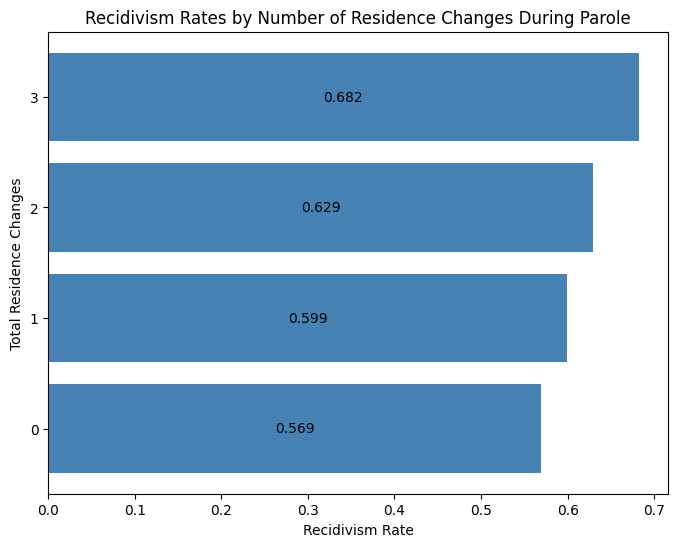

In [47]:
rsdnc_chngs_recidivism = ga.groupby(by = ['residence_changes'])['recidivism_within_3years'].value_counts(normalize=True)
rsdnc_chngs_recidivism = pd.DataFrame(rsdnc_chngs_recidivism)

fig, ax = plt.subplots(figsize = (8,6))

y_vals = [val for val, bool in rsdnc_chngs_recidivism.index[::2]]
recid_pcts = [round(val,3) for val in rsdnc_chngs_recidivism['recidivism_within_3years'][::2]]
rc_plot = ax.barh(y=y_vals, 
    width=recid_pcts, color='steelblue')
ax.bar_label(rc_plot, label_type='center')
ax.set(title='Recidivism Rates by Number of Residence Changes During Parole', xlabel='Recidivism Rate', ylabel='Total Residence Changes', yticks=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.show();

As we saw above, moving without permission is a parole violation and had a ~5% discrepancy in recividism rates between those who violated this parole condition and those who did not. In the residence changes plot above, there does seem to be a slight linear trend between the number of moves and likelihood of recidivism. 

This is not to say that changing addresses means that someone is more likely to be rearrested, but could be related to other factors. For example, if a person is changing addresses more often, they could have a harder time attending their probation services (mental health/substance abuse programs), getting to work if they are employed, or may simply forget to report a new residence. Any combination of these could lead to a higher likelihood of recidivating.

#### Conditions of Parole Release

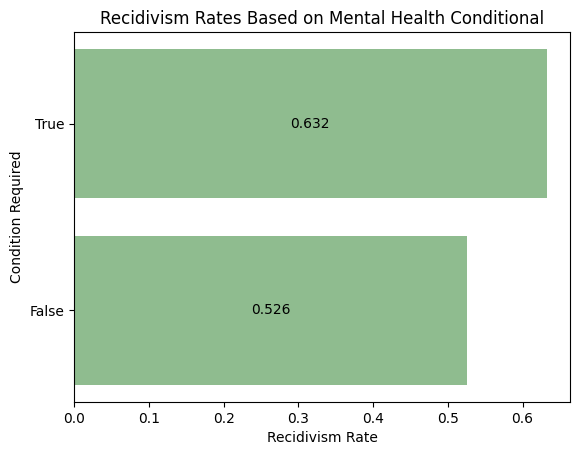

In [39]:
mentalhealth_subabuse_recidivism = ga.groupby(by = ['condition_mh_sa'])['recidivism_within_3years'].value_counts(normalize=True)
mentalhealth_subabuse_recidivism = pd.DataFrame(mentalhealth_subabuse_recidivism)

fig, ax = plt.subplots()

y_vals = [val for val in mentalhealth_subabuse_recidivism.index[0]]
recid_pcts = [round(val,3) for val in mentalhealth_subabuse_recidivism['recidivism_within_3years']]
mh_sa_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='darkseagreen')
ax.bar_label(mh_sa_plot, label_type='center')
ax.set(title='Recidivism Rates Based on Mental Health Conditional', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Condition Required')
plt.show();

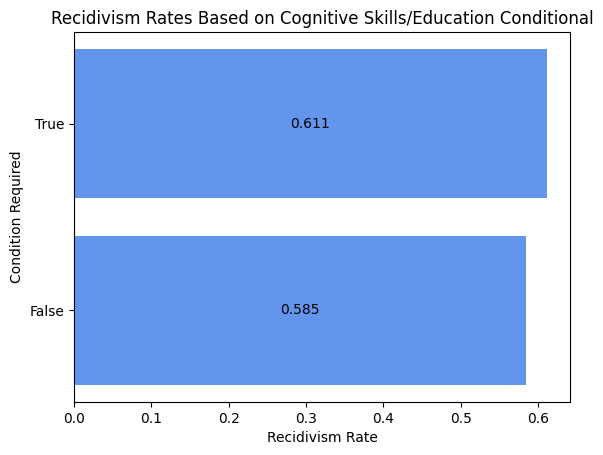

In [40]:
cog_ed_recidivism = ga.groupby(by = ['condition_cog_ed'])['recidivism_within_3years'].value_counts(normalize=True)
cog_ed_recidivism = pd.DataFrame(cog_ed_recidivism)

fig, ax = plt.subplots()

y_vals = [val for val in cog_ed_recidivism.index[0]]
recid_pcts = [round(val,3) for val in cog_ed_recidivism['recidivism_within_3years']]
cog_ed_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='cornflowerblue')
ax.bar_label(cog_ed_plot, label_type='center')
ax.set(title='Recidivism Rates Based on Cognitive Skills/Education Conditional', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Condition Required')
plt.show();

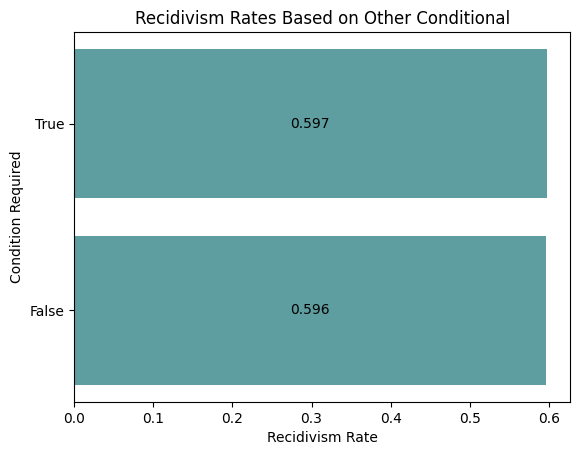

In [41]:
cond_other_recidivism = ga.groupby(by = ['condition_other'])['recidivism_within_3years'].value_counts(normalize=True)
cond_other_recidivism = pd.DataFrame(cond_other_recidivism)

fig, ax = plt.subplots()

y_vals = [val for val in cond_other_recidivism.index[0]]
recid_pcts = [round(val,3) for val in cond_other_recidivism['recidivism_within_3years']]
cond_other_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='cadetblue')
ax.bar_label(cond_other_plot, label_type='center')
ax.set(title='Recidivism Rates Based on Other Conditional', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Condition Required')
plt.show();

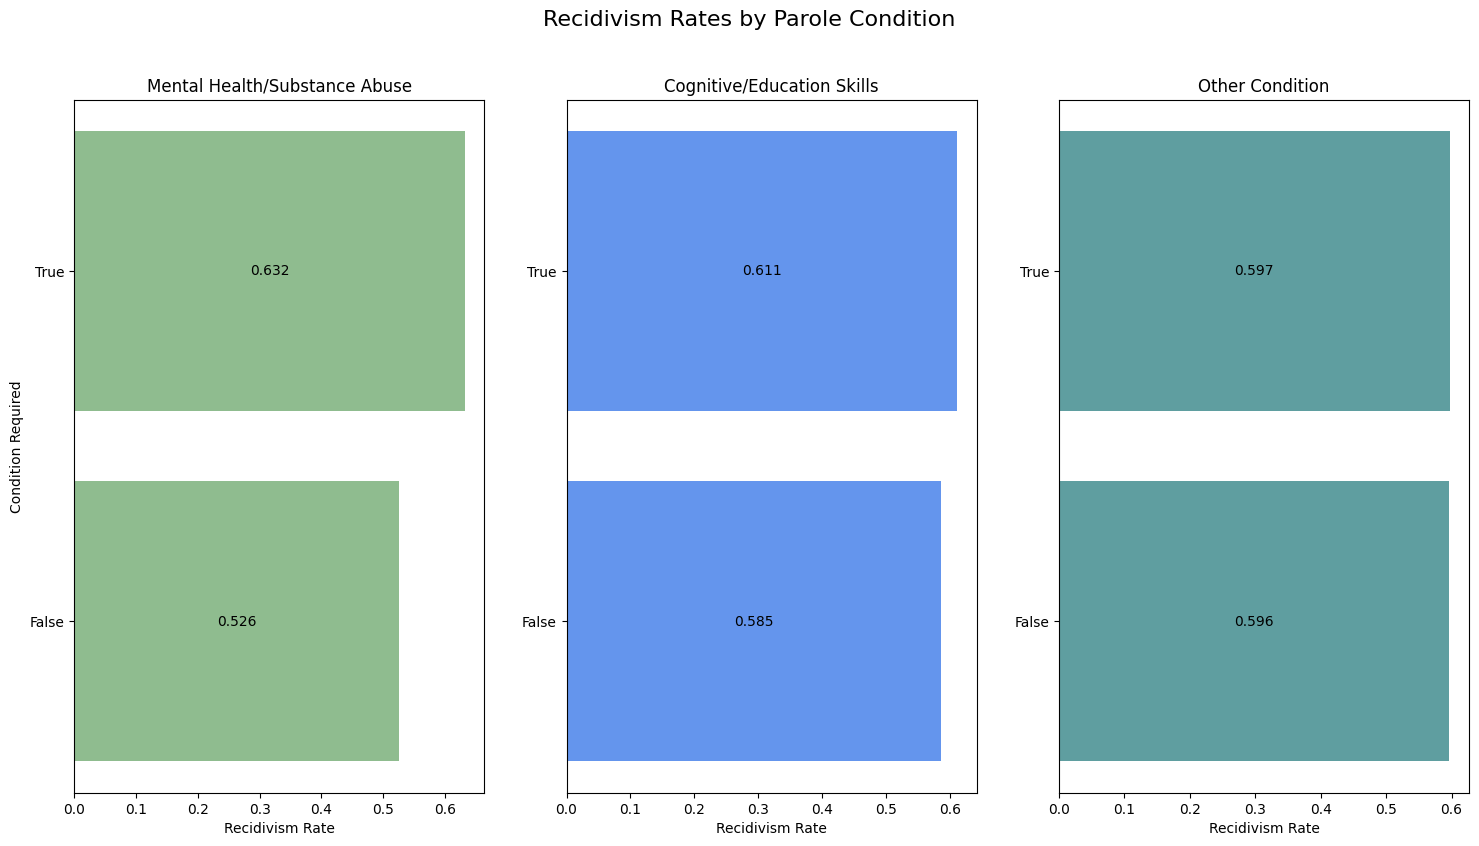

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))

y_vals = [val for val in mentalhealth_subabuse_recidivism.index[0]]
recid_pcts = [round(val,3) for val in mentalhealth_subabuse_recidivism['recidivism_within_3years']]
mh_sa_plot = ax1.barh(y=y_vals, 
    width=recid_pcts[::2], color='darkseagreen')
ax1.bar_label(mh_sa_plot, label_type='center')
ax1.set(title='Mental Health/Substance Abuse', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Condition Required')

y_vals = [val for val in cog_ed_recidivism.index[0]]
recid_pcts = [round(val,3) for val in cog_ed_recidivism['recidivism_within_3years']]
cog_ed_plot = ax2.barh(y=y_vals, 
    width=recid_pcts[::2], color='cornflowerblue')
ax2.bar_label(cog_ed_plot, label_type='center')
ax2.set(title='Cognitive/Education Skills', xlabel='Recidivism Rate', yticks=[0, 1], yticklabels=['False', 'True'])

y_vals = [val for val in cond_other_recidivism.index[0]]
recid_pcts = [round(val,3) for val in cond_other_recidivism['recidivism_within_3years']]
cond_other_plot = ax3.barh(y=y_vals, 
    width=recid_pcts[::2], color='cadetblue')
ax3.bar_label(cond_other_plot, label_type='center')
ax3.set(title='Other Condition', xlabel='Recidivism Rate', yticks=[0, 1], yticklabels=['False', 'True'])

fig.suptitle('Recidivism Rates by Parole Condition', fontsize= 16)
plt.show();

Of the three parole conditions in the chart above, we can see that the recidivism rate is greatest in those who had been required to attend mental health and/or substance abuse programming. Though difficult to make any conclusions without more information, these results may indicate that those who struggle with one or both of these issues are more likely than others to return to prison, either for a parole violation or new crime. This plot could also suggest a lack of effectiveness in the mental health/substance abuse programs. 

In the two other condition plots, there does not appear to be a strong relationship between the parole condition and likelihood of recidivism.

*Note: The 'Other' condition refers to miscellaneous parole release conditions like no victim contact, electronic monitoring, sex offender registration/program, etc.*

### Do there appear to be any mitigating factors that decrease the likelihood of recidivism?

#### Program Attendances

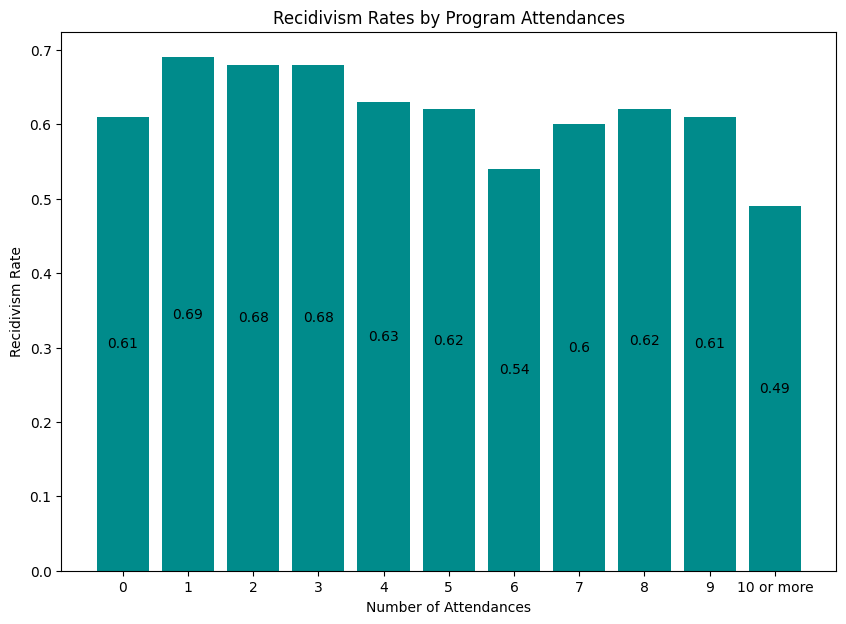

In [44]:
attendances_recidivism = ga.groupby(by = ['program_attendances'])['recidivism_within_3years'].value_counts(normalize=True)
attendances_recidivism = pd.DataFrame(attendances_recidivism)
attndnc_range = list(range(0,11))

fig, ax = plt.subplots(figsize=(10,7))

x_vals = [val for val, bool in attendances_recidivism.index[::2]]
recid_pcts = [round(val,2) for val in attendances_recidivism['recidivism_within_3years'][:-2][::2]]
recid_pcts.append(round(attendances_recidivism['recidivism_within_3years'][10][1],2))
attendance_plot = ax.bar(x=x_vals, 
    height=recid_pcts, color='darkcyan')
ax.bar_label(attendance_plot, label_type='center')
ax.set(title='Recidivism Rates by Program Attendances', xlabel='Number of Attendances', ylabel='Recidivism Rate', xticks=attndnc_range, xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, '10 or more'])
plt.show();

I expected this plot to show a more apparent downward slope - more program attendances leads to lower recidivism rate - but there is not an obvious conclusion we can clean from the results above. It does track that those who attended ten or more program sessions had the lowest average recidivism rate (0.49). This is followed by six attendances (0.54 average recidivism rate), then zero, four, five, seven, eight, and nine attendances are almost tied and all saw average rates between 0.60 and 0.63. 

What we may be able to establish here is that attending six or more program sessions while on parole could reduce the probability of reincarceration among parolees. 

#### Employment During Parole

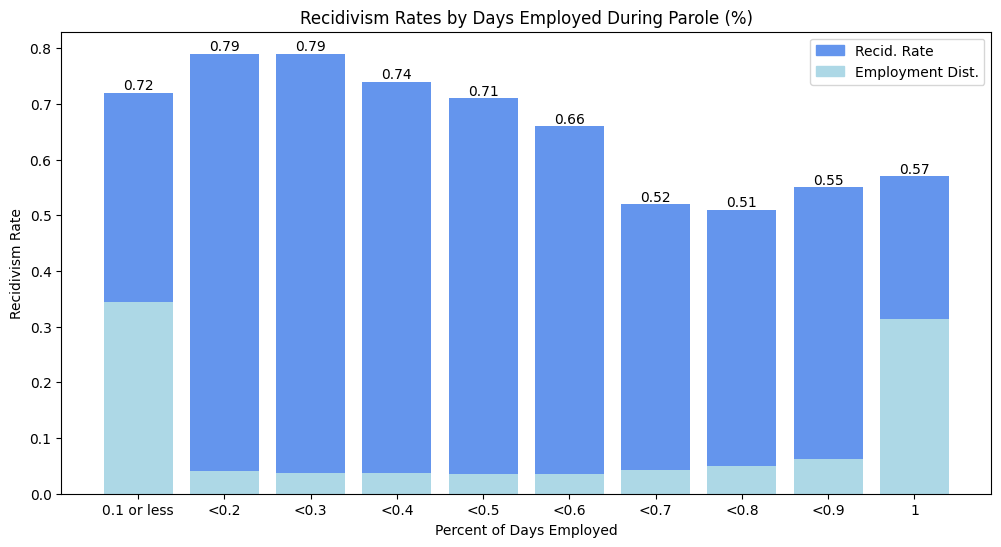

In [45]:
# Adding a column here to categorize the individual values within the pct_days_employed column

ga['pct_days_employed_categ'] = pd.cut(ga['percent_days_employed'], bins=10, labels=['0.1 or less', '<0.2', '<0.3', '<0.4', '<0.5', '<0.6', '<0.7', '<0.8', '<0.9', '1'])

employed_recidivism = ga.groupby(by = ['pct_days_employed_categ'])['recidivism_within_3years'].value_counts(normalize=True)
employed_recidivism = pd.DataFrame(employed_recidivism)

fig, ax = plt.subplots(figsize=(12,6))

x_vals = [val for val, bool in employed_recidivism.index[::2]]
recid_pcts = [round(val,2) for val in employed_recidivism['recidivism_within_3years'][::2]]
emp_plot = ax.bar(x=x_vals, height=recid_pcts, color='cornflowerblue')
ax.bar(height= ga['pct_days_employed_categ'].value_counts(normalize=True).sort_index(axis=0), x=x_vals, color='lightblue')
ax.bar_label(emp_plot, label_type='edge')
ax.set(title='Recidivism Rates by Days Employed During Parole (%)', xlabel='Percent of Days Employed', ylabel='Recidivism Rate')
recid_rates = mpatches.Patch(color='cornflowerblue', label='Recid. Rate')
days_emp_pcts = mpatches.Patch(color='lightblue', label='Employment Dist.')
plt.legend(handles=[recid_rates, days_emp_pcts])
plt.show();

There are a few key takeaways from the chart above:
1. Looking at all recidivism averages, we can see an obvious downtrend as the percent of days employed during parole increase, implying an inverse relationship between these two features.
2. The secondary bar plot (noted in the plot legend) shows the distribution of how many individuals of the almost 25,000 in the cleaned dataset were included in each category. This is meant to provide the viewer with more transparency around each of the recidivism percents, as we don't want to overinflate the weight or meaning of employment during parole. 
3. Because the number of people who fall into each category is much lower for the 20% through 90% groups, we can also look at this plot just for the majority classes that make up more than 60% of the total - individuals who were employed more than 90% of the time, or less than 10% of the time (in the '0.1 or less' category, 7,448 of these were 0% and 940 were between 0 and 0.1). The 0.57 average recidivism rate of those who spent more time employed is noticeably less than the 0.72 average seen for those who spent less than 10% of days employed.

*Note: Some individuals in the dataset were exempt from employment, meaning that even though they will be categorized here in the '0.1 or less' group, it should be noted that not all of these are due to voluntary lack of employment.*

#### Drug Test Frequency

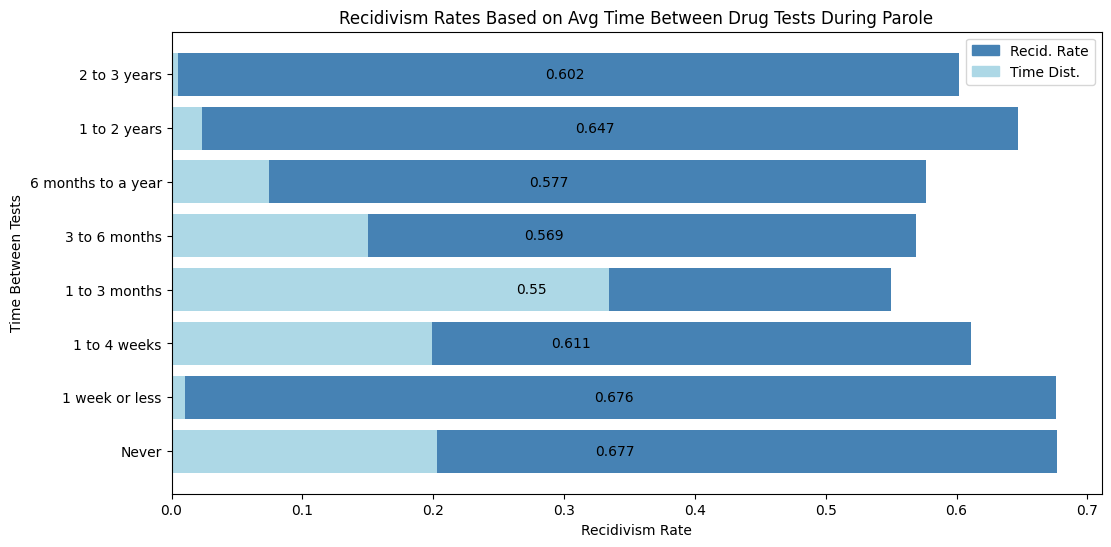

In [48]:
# Similar to pct_days_employed and prior_arrests, adding a column here so that we're able to categorize the coontinuous values in the avg_days_per_drugtest column

ga['avg_days_per_drugtest_categ'] = pd.cut(ga['avg_days_per_drugtest'], bins=[0, 1, 7, 30, 90, 180, 365, 730, 1095], right=True, labels=['Never', '1 week or less', '1 to 4 weeks', '1 to 3 months', '3 to 6 months', '6 months to a year', '1 to 2 years', '2 to 3 years'], include_lowest=True)

avg_days_drugtest_recidivism = ga.groupby(by = ['avg_days_per_drugtest_categ'])['recidivism_within_3years'].value_counts(normalize=True)
avg_days_drugtest_recidivism = pd.DataFrame(avg_days_drugtest_recidivism)

fig, ax = plt.subplots(figsize=(12,6))

y_vals = [val for val, bool in avg_days_drugtest_recidivism.index[::2]]
recid_pcts = [round(val,3) for val in avg_days_drugtest_recidivism['recidivism_within_3years'][::2]]
avg_days__plot = ax.barh(y=y_vals, width=recid_pcts, color='steelblue')
ax.barh(width= ga['avg_days_per_drugtest_categ'].value_counts(normalize=True).sort_index(axis=0), y=y_vals, color='lightblue')
ax.bar_label(avg_days__plot, label_type='center')
ax.set(title='Recidivism Rates Based on Avg Time Between Drug Tests During Parole', xlabel='Recidivism Rate', ylabel='Time Between Tests')
recid_rates = mpatches.Patch(color='steelblue', label='Recid. Rate')
days_btwn_pcts = mpatches.Patch(color='lightblue', label='Time Dist.')
plt.legend(handles=[recid_rates, days_btwn_pcts])
plt.show();

The greatest average recidivism rates were seen in individuals who were not tested for drugs at all during their parole, or who were tested every week. We can also see that most people in the dataset received a drug test every one to three months, and that this is the group that had the lowest average recidivism rate.

Without more information, we're unable to make any meaningful judgments about the effectiveness of drug testing individuals more or less frequently during their parole. 

**Combined/Summary Visualizations**

**FINAL NOTES:**
- All visualizations from this EDA exercise can be found in the **visualizations** directory.
- There is no data output from this notebook.
- The next notebook in the series is [Modeling](./03_modeling.ipynb).